## Continuation of 09:

## Alternative: Maybe rather that "forget  the violating trajectory", we should get as close as possible to the average of both?



#### Take the easier step with straight lines first: weight depends on *amount* of violation. This is only C1 continuous, but let's see what happens:


In [11]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import numpy.linalg as la
from matplotlib import gridspec
    
    
def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples
import toric.shims

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def drawSetup(subfig, PA, PB, C0, C1, mindist, fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):

    subfig.set_aspect('equal')
    fig = subfig
    
    # Set up plot size
    subfig.set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    subfig.set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    subfig.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)
    line_AB = plt.Line2D([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()], c="black",alpha=0.3)
    subfig.add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)
    
    subfig.add_artist(circle_PA_1)
    subfig.add_artist(circle_PB_1)

    subfig.annotate(s="A", xy=(PA_1.x(),PA_1.y()),xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="B", xy=(PB_1.x(),PB_1.y()),xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    subfig.scatter([C_0.x(), C_1.x()],[C_0.y(), C_1.y()],c="blue",linewidths=0)
    subfig.annotate(s="C0", xy=(C_0.x(), C_0.y()),xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="C1", xy=(C_1.x(), C_1.y()),xytext=(3,4),textcoords="offset points")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
min_dist = 1                    # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-1.1,-0.2,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 2.1,-0.2,0)    # Ending camera position

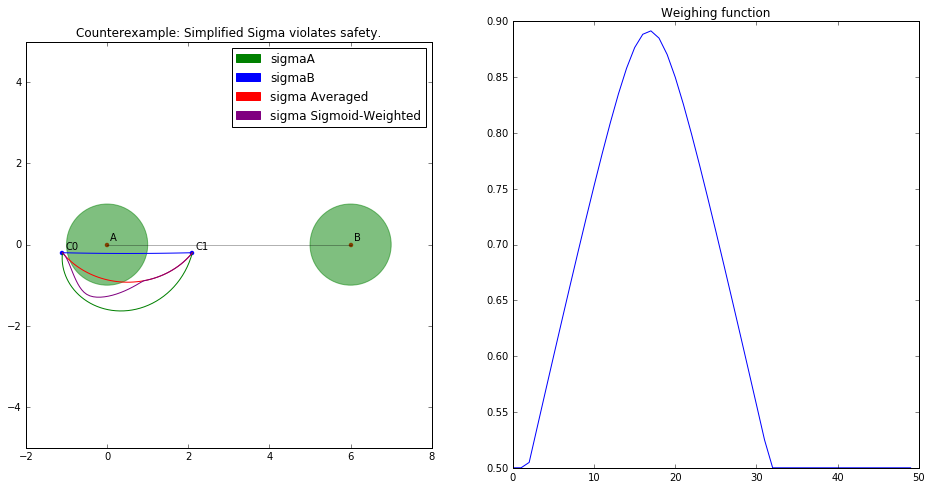

In [13]:
# Create Numpy arrays
A = PA_1.np()
B = PB_1.np()
C0 = C_0.np()
C1 = C_1.np()

# Set up interpolation vector
u = np.c_[np.linspace(0,1)]

# Set up the distance components of sigmaA, sigmaB
dA0 = la.norm(C0 - A)
dA1 = la.norm(C1 - A)
dB0 = la.norm(C0 - B)
dB1 = la.norm(C1 - B)

dA = np.linspace(dA0, dA1)
dB = np.linspace(dB0, dB1)

# Set up the vantage vector components of sigmaA, sigmaB
vA0 = (C0 - A) / dA0
vA1 = (C1 - A) / dA1
vB0 = (C0 - B) / dB0
vB1 = (C1 - B) / dB1

vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

# Set up sigmaA, sigmaB, sigma
sigmaA = A + dA[:,np.newaxis] * vA
sigmaB = B + dB[:,np.newaxis] * vB


def calc_weight(sigma_i, sigma_j, i, j):
    def silly_map(sigmas):
        sigmaiu = sigmas[0:3]
        sigmaju = sigmas[3:6]
        if la.norm(sigmaju - i) < min_dist:
            return np.interp(la.norm(sigmaju - i), [0, min_dist], [1, 0.5])
        elif la.norm(sigmaiu - j) < min_dist:
            return np.interp(la.norm(sigmaiu - j), [0, min_dist], [0.5, 0])
        else:
            return 0.5
    
    return np.apply_along_axis(silly_map, axis=1, arr=np.c_[sigma_i, sigma_j]) 

wA = calc_weight(sigmaA, sigmaB, A, B)

sigmaWeighted = (wA[:,np.newaxis]*sigmaA + (1 - wA)[:,np.newaxis]*sigmaB)
sigmaAvg = (sigmaA + sigmaB)/2

pylab.rcParams['figure.figsize'] = 16, 8
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1]) 
fig = plt.figure()
f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])

drawSetup(f1, PA_1, PB_1, C0, C1, min_dist,fudgeY_neg=(4+min_dist),fudgeY_pos=(4+min_dist),fudgeX=1+min_dist)
f1.plot(sigmaA[:,0],sigmaA[:,1], c="green")
f1.plot(sigmaB[:,0],sigmaB[:,1], c="blue")
f1.plot(sigmaAvg[:,0], sigmaAvg[:,1],  c="red")
f1.plot(sigmaWeighted[:,0], sigmaWeighted[:,1],  c="purple")

f1.set_title("Counterexample: Simplified Sigma violates safety.")

sA_legend = mpatches.Patch(color="green", label="sigmaA")
sB_legend = mpatches.Patch(color="blue", label="sigmaB")
SA_legend  = mpatches.Patch(color="red", label="sigma Averaged")
SW_legend  = mpatches.Patch(color="purple", label="sigma Sigmoid-Weighted")

f1.legend(handles=[sA_legend,sB_legend,SA_legend,SW_legend])


f2.plot(wA)
f2.set_title("Weighing function")

### Observation: This is "better" (we get closer to the averaged trajectory than previous) but it's silly. Why veer so far away? Becuse we un-weigh the blue the worse it gets, this doesn't make sense either.


### I believe this becomes an optimization problem, of finding a weighing function under a set of constraints and energy minimizations
